# Gloss Analysis - DO NOT UPLOAD TO PUBLIC REPO
In this notebook, we analyze the ways in which the Corpus NGT videos are annotated. First, we store the annotations in a nested dictionary, where `anns_dicts` has a key for each annotation file (e.g. `S001_CNGT0090.eaf` is a key for the dictionary). We will call these video keys. For each of these video keys, we have *another* dictionary, where each key is equal to a gloss/sign, a sign key. So, in `anns_dicts['S001_CNGT0090.eaf']`, we find this nested dictionary with for instance the sign `HOND-A` as one of its sign keys. This sign key then lets us access the timestamps (in milliseconds) where that sign is annotated. For instance `anns_dicts['S001_CNGT0090.eaf']['HOND-A']` could return `[(0,100), (200, 350)]`, which would mean that the sign `HOND-A` is signed from 0 to 100 ms and again from 200 to 350ms in the video of `S001_CNGT0090`.

We check how often signs are signed in some specific way:
- Manual simultaneity: two signs, both performed with one hand, are signed at the same time
- Two-handedness: both hands are annotated as signing the same sign simultaneously
- Weak hand drop: a sign is performed with two-hands normally, but only one hand is annotated as performing the sign

Based on this, we check how often these types of sign instances occur.

The average duration of an annotation is computed here, both with outliers and without. We then get only the top X (e.g. top 1000) signs based on how often they're annotated. For each of these annotations, we also check how many of the frames are properly recognized by Mediapipe (i.e. landmarks are detected).
Additionally, we compare what signs are present in the Corpus NGT videos versus NGT SignBank to see how representative the Corpus is of the known signs in Dutch sign language.

In [1]:
# Imports
import pympi
import re
import copy
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing

import importlib

# Keep python tools up to date
from tools import tools, constants
importlib.reload(tools)
importlib.reload(constants)

# Import all functions from the tools
from tools.tools import*
from tools.constants import PATHS # Path constants

# SignBank gloss analysis

In [2]:
%%time
# Root where all the annotated .eaf sign files are present
dataset_root = PATHS['cngt_vids_and_eaf']

# List the .eaf files in the root directory to investigate
anns_in_dir = [file for file in os.listdir(dataset_root) if file.endswith('.eaf')]

# Initialize list of all gloss annotations
tiers = []
anns_dicts = {}
mouthings_dicts = {}
destination = PATHS['cngt_anns']
if not os.path.exists(destination):
    for ann_file in anns_in_dir:
        # Read in the Eaf file 
        eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, ann_file))

        # Get the glosses and mouthings of the file
        anns_dict, mouthings_dict = get_gloss_vals(eaf_file)

        # Store the glosses, mouthings and tiers
        anns_dicts[ann_file] = anns_dict
        mouthings_dicts[ann_file] = mouthings_dict
        tiers += get_tiers(eaf_file)

    # print(list(set(tiers)))
    store_dict(destination, anns_dicts)
else:
    anns_dicts = load_dict(destination)

CPU times: total: 203 ms
Wall time: 200 ms


In [3]:
total_anns = 0
for key in anns_dicts:
    val = anns_dicts[key]
    for val_key in val:
        vals = val[val_key]
        len_vals = len(vals)
        total_anns += len_vals

print("Total number of annotations:", total_anns)

Total number of annotations: 162145


In [4]:
%%time
# Getting annotations, separated by simultaneity and handedness
man_sim_hand_dist = {}
man_sim_hand_dist_path = PATHS['man_sim_hand_dist']
if not os.path.exists(man_sim_hand_dist_path):
    for i, key in enumerate(anns_dicts):
        print(i, end = '\r')
        # Getting the annotations for a specific EAF file
        anns_dict = anns_dicts[key]
        # Computing hand distinction + manual simultaneity instances
        # Make a deepcopy of the anns_dict because we don't want to alter the arrays within it
        # (Which would happen if we didn't copy at all or only did shallow copies)
        man_sim_hand_dist[key] = man_sim_and_hand_dist(copy.deepcopy(anns_dict))
    store_dict(man_sim_hand_dist_path, man_sim_hand_dist)
else:
    man_sim_hand_dist = load_dict(man_sim_hand_dist_path)

CPU times: total: 172 ms
Wall time: 162 ms


In [5]:
keys = list(man_sim_hand_dist.keys())
# Print some examples of the dictionary keys and the keys of a nested dictionary within it
print('Keys in man_sim_hand_dist: {}'.format(keys[:10]))
print('Keys in man_sim_hand_dist[\'{}\']: {}'.format(keys[0], man_sim_hand_dist[keys[0]].keys()))

Keys in man_sim_hand_dist: ['S001_CNGT0090.eaf', 'S001_CNGT0091.eaf', 'S001_CNGT0093.eaf', 'S001_CNGT0094.eaf', 'S001_CNGT0095.eaf', 'S001_CNGT0096.eaf', 'S001_CNGT0097.eaf', 'S001_CNGT0098.eaf', 'S001_CNGT0099.eaf', 'S001_CNGT0101.eaf']
Keys in man_sim_hand_dist['S001_CNGT0090.eaf']: dict_keys(['PALM-UP', 'PT-1hand:1', 'SELF-A', 'PT-1hand', '100-A', '30-A', 'FINISHED-A', '#AN', 'SCHOOL-A', 'FAMILY-C', '2-A', '[NAAM]', 'DEAF-A', 'SPACE-A', '1-A', 'HEAR-A', 'FINE', 'NAME-C', '#K', '#[naam]', 'PARENT-B', 'ALSO-A', 'SIBLING-A', '~KLEIN-A', 'CHILD.PL', 'LARGE-VERTICAL-F', 'NEAR-C', 'SMALL-VERTICAL-F', 'PALM-UP&&WORK-A', 'PALM-UP__2H', 'CONFUSED-B__2H', 'WORK-A__2H', '19-C__2H', '7-A__2H', 'FINISHED-A__2H', 'BORN-A__2H', 'AMSTERDAM__2H', 'FOLLOW__2H', 'THEN-A__2H', 'PT-1hand__2H', 'SIGN-A__2H'])


In [6]:
# Currently the dictionaries are grouped by EAF file: i.e. {'EAF_001': {...}, 'EAF_002': {...}}
# We now fuse these groupings
fused_man_sim_hand_dist = fuse_ann_values(man_sim_hand_dist)
fused_anns_dicts = fuse_ann_values(copy.deepcopy(anns_dicts))

In [7]:
# Splitting each annotation value into its name value and its time value
t_man_sim_hand_dist, a_man_sim_hand_dist = split_ann_values(fused_man_sim_hand_dist)
t_anns_dicts, a_anns_dicts = split_ann_values(fused_anns_dicts)

In [8]:
# Checking the number of manual simultaneity instances
manual_sim_counts = [(k,len(v)) for k,v in fused_man_sim_hand_dist.items() if '&&' in k]

# Checking the number of two-handed instances
two_handed_counts = [(k,len(v)) for k,v in fused_man_sim_hand_dist.items() if '__2H' in k]

m_s_c_sorted = sorted(manual_sim_counts, key = lambda x: x[1], reverse = True)

zipped = list(zip(*m_s_c_sorted))
keys = zipped[0]
values = zipped[1]

print('Total manual simultaneity instances:', sum(values), '\nIndividual counts (top 100):\n', list(values[:100]))

print('\nTotal two-handed instances:', sum([t[1] for t in two_handed_counts]))

Total manual simultaneity instances: 17428 
Individual counts (top 100):
 [456, 326, 313, 306, 121, 105, 103, 92, 84, 78, 66, 66, 63, 62, 62, 60, 58, 56, 53, 49, 45, 45, 43, 39, 39, 37, 37, 37, 34, 34, 33, 33, 33, 32, 32, 31, 29, 29, 28, 28, 27, 26, 26, 26, 26, 25, 25, 25, 25, 24, 24, 23, 23, 23, 23, 22, 22, 22, 22, 21, 21, 21, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15]

Total two-handed instances: 39541


In [9]:
# For the next analysis for which we use two-handedness as a factor
# We need to be using the annotations values with handedness disctinction
one_handed = [ann for ann in a_man_sim_hand_dist if '__2H' not in ann]
two_handed = [ann for ann in a_man_sim_hand_dist if '__2H' in ann]

In [10]:
from itertools import chain
one_handed_expanded = list(set(list(chain(*[x.split('&&') for x in one_handed]))))

In [11]:
# Read in the signs with the corresponding names
gloss_df = pd.read_csv(PATHS['signbank_dictionary_info'])
# Get the signs where the handedness is known and is equal to 2 (so: two-handed signs)
normally_two_handed = gloss_df[(gloss_df['Handedness'].str.contains('2'))&(~gloss_df['Handedness'].isna())]
print('Signs normally performed two-handed (preview)')
display(normally_two_handed['Annotation ID Gloss (Dutch)'])

# Finding which signs are signed seemingly one-handedly despite normally being two-handed
# This could indicate weak hand drop
weak_hand_drop = normally_two_handed[normally_two_handed['Annotation ID Gloss (Dutch)'].isin(one_handed)]
print('Weak hand drop candidates (two-handed signs which are performed one-handed)')
display(weak_hand_drop['Annotation ID Gloss (Dutch)'])

# Finding which signs are signed seemingly one-handedly despite normally being two-handed
# This could indicate weak hand drop
weak_hand_drop_expanded = normally_two_handed[normally_two_handed['Annotation ID Gloss (Dutch)'].isin(one_handed_expanded)]
print('Weak hand drop candidates (including manual simultaneous instances)')
display(weak_hand_drop_expanded['Annotation ID Gloss (Dutch)'])

Signs normally performed two-handed (preview)


7        MISHANDELEN
8       ACCEPTEREN-A
9       ACCEPTEREN-B
11         ONGELUK-A
12         ONGELUK-B
            ...     
4136             7-B
4139            70-C
4143              77
4145             8-B
4152             9-B
Name: Annotation ID Gloss (Dutch), Length: 1678, dtype: object

Weak hand drop candidates (two-handed signs which are performed one-handed)


21            BEZIG
23        AANPASSEN
63          TEGEN-A
68       MEE-EENS-B
77       ALLEMAAL-A
           ...     
4074           19-C
4075           19-D
4080    1:OVERNEMEN
4139           70-C
4145            8-B
Name: Annotation ID Gloss (Dutch), Length: 447, dtype: object

Weak hand drop candidates (including manual simultaneous instances)


8       ACCEPTEREN-A
9       ACCEPTEREN-B
12         ONGELUK-B
21             BEZIG
23         AANPASSEN
            ...     
4128         6.ORD-B
4136             7-B
4139            70-C
4145             8-B
4152             9-B
Name: Annotation ID Gloss (Dutch), Length: 859, dtype: object

In [12]:
# Counting how often weak-hand drop candidates are actually signed that way
# And how often they're signed normally (i.e. two-handedly)
one_handed_counts, two_handed_counts = get_weak_hand_drop_counts(weak_hand_drop, list(set(one_handed)), two_handed)

# Grouping the counts of the two handed signs with handedness distinguisher together
# So: we count how many times it's signed with weak hand drop, without weak hand drop, and in total (not distinguishing)
sorted_two_hand_no_suffix = {s[0][:-4]: s[1] for s in two_handed_counts}
sorted_one_hand = dict(one_handed_counts)

both_hands = merge_dicts(sorted_two_hand_no_suffix, sorted_one_hand)
print('Counts of two-handed signs with weak hand drop')
print('Each triple: (num_two_handed_signings, num_weak_hand_drops, total_signings)')
sorted(both_hands.items(), key=lambda item: item[1][1], reverse = True)

Counts of two-handed signs with weak hand drop
Each triple: (num_two_handed_signings, num_weak_hand_drops, total_signings)


[('PO', (5556, 1, 5557)),
 ('GEBAREN-A', (1532, 1, 1533)),
 ('ZELFDE-A', (740, 1, 741)),
 ('GEHANDICAPT-A', (371, 1, 372)),
 ('KLAAR-A', (328, 1, 329)),
 ('WERKEN-A', (306, 1, 307)),
 ('GROEP-A', (298, 1, 299)),
 ('SAMEN-A', (269, 1, 270)),
 ('TOCH-A', (256, 1, 257)),
 ('NIET-C', (237, 1, 238)),
 ('AL', (227, 1, 228)),
 ('PV', (212, 1, 213)),
 ('ONTWIKKELEN-A', (202, 1, 203)),
 ('PLUS-A', (200, 1, 201)),
 ('NIET-B', (199, 1, 200)),
 ('BLIJVEN', (194, 1, 195)),
 ('TWIJFEL-A', (192, 1, 193)),
 ('ZO', (167, 1, 168)),
 ('GEBOREN-A', (165, 1, 166)),
 ('COMMUNICEREN', (156, 1, 157)),
 ('CONTACT-MAKEN', (152, 1, 153)),
 ('PRATEN-B', (148, 1, 149)),
 ('GEBAREN-C', (145, 1, 146)),
 ('OF', (142, 1, 143)),
 ('TAAL-B', (137, 1, 138)),
 ('VOGEL-A', (136, 1, 137)),
 ('JAAR-B', (136, 1, 137)),
 ('ZELFDE-B', (135, 1, 136)),
 ('VRIEND-A', (135, 1, 136)),
 ('BIJVOORBEELD-B', (129, 1, 130)),
 ('AMSTERDAM', (127, 1, 128)),
 ('VERSCHIL-A', (126, 1, 127)),
 ('DOEN-A', (121, 1, 122)),
 ('ALLES-A', (119, 1, 1

In [13]:
# Make the timespan distinctions into a list
lst_time_values = [t_man_sim_hand_dist, t_anns_dicts]
lst_anns_values = [a_man_sim_hand_dist, a_anns_dicts]

# Selecting a specific distinction (handedness + manual sim. = 0, no distinction = 1)
# Ind = 1 should be used for finding out what the top 1000 signs are for creating the dataset
# Whereas ind = 0 is used for analysis of the handedness and simultaneous signs
ind = 1
anns_values = lst_anns_values[ind]
time_values = lst_time_values[ind]
time_deltas = [abs(t[1] - t[0]) for t in time_values] # in ms

counts = Counter(time_deltas)
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1]))#Counter(time_deltas)

most_common = counts.most_common()

print('max', max(time_deltas))

# Creates a plot of the counts
# plot_counts(most_common)

get_duration_stats(time_deltas)

max 44080
Avg timespan length:	~10 frames 	(395.3 ms)
Median timespan length:	~7 frames 	(280.0 ms)
Max timespan length:	~1102 frames 	(44080 ms)
Min timespan length:	~0 frames 	(1 ms)


In [14]:
# Removing outliers
from scipy import stats
time_deltas = np.array(time_deltas)
z = np.array(stats.zscore(time_deltas))
non_outliers = np.where(z<3)
print(time_deltas.shape)
time_deltas_filtered = time_deltas[non_outliers]
print(time_deltas_filtered.shape)

print('With outlier removal:')
get_duration_stats(time_deltas_filtered)

(162145,)
(159787,)
With outlier removal:
Avg timespan length:	~9 frames 	(356.3 ms)
Median timespan length:	~7 frames 	(280.0 ms)
Max timespan length:	~46 frames 	(1840 ms)
Min timespan length:	~0 frames 	(1 ms)


In [15]:
print('Number of annotations:', len(time_deltas))
time_deltas = np.array(time_deltas)
limit = 5000
time_deltas_filter = np.where(time_deltas <= limit)[0] # 5 seconds or shorter annotations (>99% of annotations)
old_shape, new_shape = time_deltas.shape[0], time_deltas_filter.shape[0]
print('Values left after filtering for duration <= {}: {}%'.format(limit, round(100*new_shape/old_shape, 2)))
filtered_anns_values = np.array(anns_values)[time_deltas_filter].tolist()

Number of annotations: 162145
Values left after filtering for duration <= 5000: 99.89%


In [16]:
plot = False
# Count up the glosses
counts = Counter(filtered_anns_values)

# Get the most common glosses, print and plot them
# 250 works okay for plotting non-log, more = hardly readable
# 2500 looks readable in logarithmic
top_n = 500
most_common = counts.most_common(top_n) #top_n
# print(most_common)

# Creates a list of glosses and a list of counts
if plot:
    plt.figure(figsize=(8,4))
    plt.title('Counts of the {} most common glosses (logarithmic)'.format(top_n))
    plt.yscale("log")
    plot_counts(most_common, width = 30, clean = True)

# Printing some sign counts
print('Most common sign: {}'.format(most_common[0]))
print('{}th most common sign: {}'.format(top_n, most_common[-1]))

Most common sign: ('PO', 15734)
500th most common sign: ('WEEKEND-A', 48)


In [17]:
# Without distinctions, we can capture the most common signs
# Otherwise a manual sim. instances is counted as sign of its own

# Signbank dictionary info
df = pd.read_csv(PATHS['signbank_dictionary_info'])

dutch_anns = []
if ind == 1:
    for i, gloss in enumerate(anns_values):
        print('{}/{}'.format(i, len(anns_values)), end = '\r')
        dutch_name = df.loc[df['Annotation ID Gloss (English)']==gloss]['Annotation ID Gloss (Dutch)']
        # Also check if it isn't already Dutch
        already_dutch = df.loc[df['Annotation ID Gloss (Dutch)']==gloss]['Annotation ID Gloss (Dutch)']
        # Check if there's any English entries equal to this annotation, if so we map to Dutch
        if dutch_name.shape[0] > 0:
            dutch_gloss = dutch_name.tolist()[0]
        elif already_dutch.shape[0] > 0:
            dutch_gloss = gloss
        else: continue
        dutch_anns.append(dutch_gloss)
    dutch_counts = Counter(dutch_anns)
    dutch_most_common = dutch_counts.most_common()
    top = -1
    if top != -1: # -1 is using all signs
        top_signs = dutch_most_common[:top] 
    else:
        top_signs = dutch_most_common
    print(top_signs)
    top_signs = np.array([x[0] for x in top_signs])
    print(top_signs)
    np.save(PATHS['top_signs'].format(top), top_signs)
    

[('PO', 15921), ('PT-1hand', 15078), ('PT-1hand:1', 8630), ('GEBAREN-A', 3115), ('ZELFDE-A', 1508), ('JA-A', 1384), ('PO+PT', 1337), ('GOED-A', 1298), ('KUNNEN-A', 1222), ('ATTENTIE', 998), ('HOREN-A', 941), ('WETEN-A', 876), ('GEHANDICAPT-A', 748), ('HEE', 732), ('ZIEN-A', 730), ('KLAAR-A', 719), ('1-A', 719), ('NIET-A', 708), ('AL', 689), ('ZEGGEN', 669), ('DOOF-A', 650), ('ZELF-A', 647), ('TWIJFEL-A', 646), ('GAAN-NAAR-A', 641), ('WERKEN-A', 619), ('NU-A', 615), ('LAAT-MAAR', 608), ('GROEP-A', 608), ('PV', 604), ('KIJKEN-A', 600), ('MOETEN-A', 590), ('DAN-A', 551), ('HEBBEN-A', 550), ('BLIJVEN', 523), ('SAMEN-A', 522), ('TOCH-A', 519), ('DOOF-C', 513), ('NIET-B', 510), ('VROEGER-A', 504), ('NIET-C', 489), ('imitatie', 485), ('DOOF-B', 463), ('OF', 449), ('ONDERWIJS-A', 444), ('ZO', 442), ('RUIMTE-A', 430), ('OOK-A', 426), ('MOVE+1', 422), ('ONTWIKKELEN-A', 405), ('PLUS-A', 403), ('KRACHT', 399), ('OMDAT-A', 390), ('2-A', 389), ('PRATEN-A', 363), ('BEDOELEN', 361), ('GEBOREN-A', 354)

In [18]:
# The results here will be empty if we chose ind = 0 before, results are only given for ind = 1
# Because then we actually tracked manual simultaneity and two-handedness
print('Occurences of "GEBAREN":', [m for m in most_common if 'GEBAREN' in m[0]])
print('\nOccurencess of manual simultaneity:\n\n{}'.format([m for m in most_common if '&&' in m[0]]))
print('\nOccurencess of two-handedness:\n\n{}'.format([m for m in most_common if '__2H' in m[0]]))

Occurences of "GEBAREN": [('GEBAREN-A', 3090), ('GEBAREN-C', 294), ('GEBAREN-B', 99), ('~GEBAREN-A', 66)]

Occurencess of manual simultaneity:

[]

Occurencess of two-handedness:

[]


In [19]:
# Unique instances vs total instances
unique_ann_values = list(set(filtered_anns_values))
print('Total unique annotations:\t\t', len(unique_ann_values))
print('Total annotations:\t\t\t', len(filtered_anns_values))
print('\n' + '-'*30+'\n')

# Marker counts (fingerspelling, negation, uncertainty, obscured, combined)
print('Fingerspellings count (start with #)\t', count_substrings('#', filtered_anns_values)) # Start with #
print('Negations count (start with ~)\t\t', count_substrings('~', filtered_anns_values)) # Start with ~
print('Uncertainty count (end with ?)\t\t', count_substrings('?', filtered_anns_values)) # End with ?
print('Obscured count (start with !)\t\t', count_substrings('!', filtered_anns_values)) # Start with !
print('Combined sign count (contain +)\t\t', count_substrings('+', filtered_anns_values)) # Contain +
print('\n' + '-'*30+'\n')

gloss_names = gloss_df['Annotation ID Gloss (Dutch)'].tolist()

intersect = intersection(gloss_names, unique_ann_values)
print('Annotations in CNGT that occur exactly in SignBank:\t\t\t', len(intersect))

# We can do better processing of the annotations if we get rid of some markers
processed_ann_values = process_ann_values(unique_ann_values)
intersect = intersection(gloss_names, processed_ann_values)
print('Marker-filtered annotations in CNGT that occur exactly in SignBank:\t', len(intersect))


print('\n' + '-'*30+'\n')

print('Number of glosses in Signbank:', len(gloss_names))

Total unique annotations:		 5222
Total annotations:			 161961

------------------------------

Fingerspellings count (start with #)	 1574
Negations count (start with ~)		 1969
Uncertainty count (end with ?)		 595
Obscured count (start with !)		 83
Combined sign count (contain +)		 5784

------------------------------

Annotations in CNGT that occur exactly in SignBank:			 3211
Marker-filtered annotations in CNGT that occur exactly in SignBank:	 3106

------------------------------

Number of glosses in Signbank: 4159


In [20]:
signbank_not_present = set(gloss_names) - set(intersect)

In [21]:
signbank_present_df = gloss_df[gloss_df['Annotation ID Gloss (Dutch)'].isin(intersect)]
signbank_not_present_df = gloss_df[gloss_df['Annotation ID Gloss (Dutch)'].isin(signbank_not_present)]

In [22]:
# A dictionary with explanations of each column in the dataframe
# (Some of these are basically irrelevant for us but have been explained anyways)
column_meanings = {
'altern': 'alternating movement',
'contType': 'contact type',
'domhndsh': 'handshape of the dominant hand',
'excludeFromEcv': 'exclude from ECV (?)',
'handCh': 'handshape change',
'Handedness': 'handedness', #  (one handed or two handed, symmetrical or not)
'locprim': 'location (where the signing happens)' ,
'movDir': 'movement direction',
'movSh': 'movement shape',
'namEnt': 'named entity (the sign refers to?)',
'oriCh': 'orientation change',
'relOriLoc': 'relative orientation - location',
'relOriMov': 'relative orientation - movement',
'relatArtic': 'relation between articulator' ,
'repeat': 'whether the sign has repeated movement',
'subhndsh': 'handshape of the weak hand',
'valence': 'valence (positive/negative)' ,
'wordClass': 'word class' ,
'gloss_id': 'numerical ID of the gloss',
'gloss_name': 'names of the glosses',
'inWeb': 'in the web dictionary',
'isNew': 'new entries in SignBank'
}

Handedness


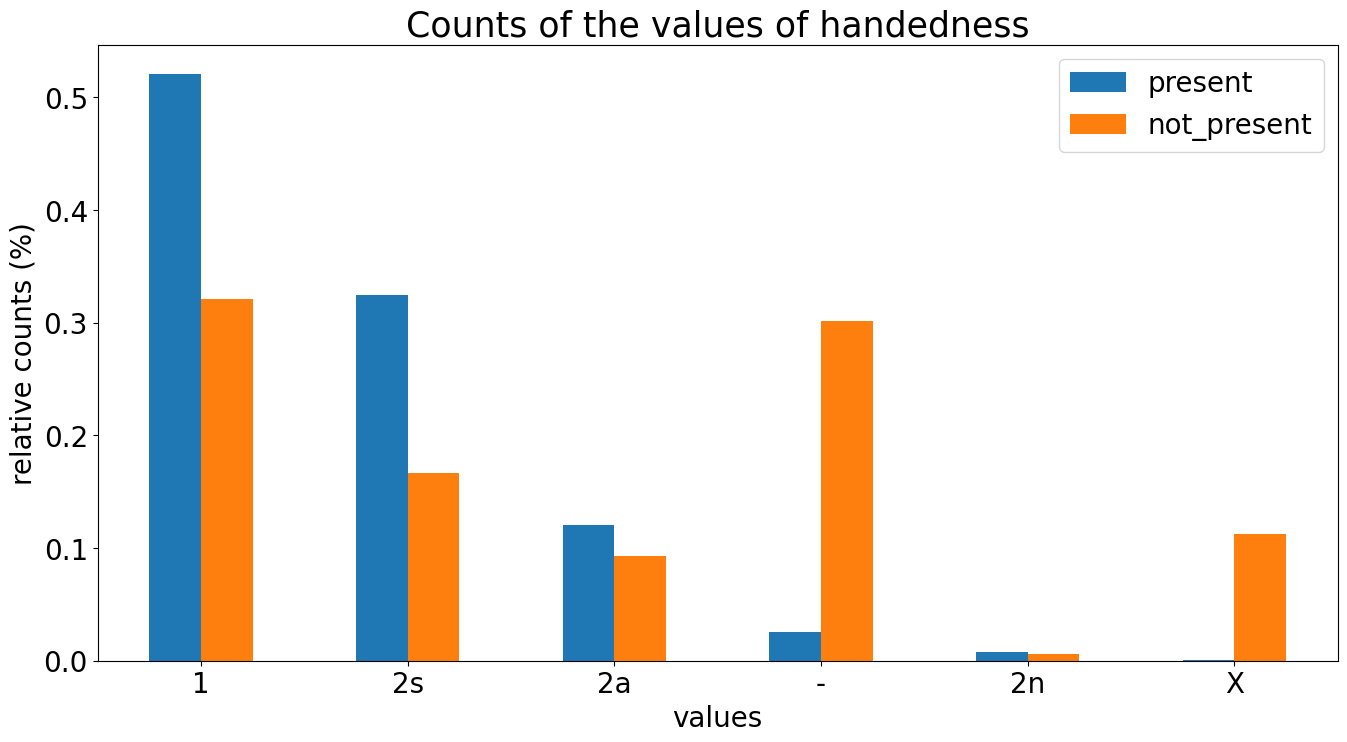

In [23]:
# Trying to capture how different the set that's signed in CNGT is compared to the one that isn't
def create_counts_df(df_present, df_not_present, col):
    df = pd.DataFrame([])
    df['present'] = df_present[col].value_counts(normalize=True)
    df['not_present'] = df_not_present[col].value_counts(normalize= True)
    return df

# List of all phonology features that are relevant for the comparison between the present and not-present signs
# Suggestion: only plot one of them each time to make sure the plotting parameters are tweaked to the exact plot
# cols = ['domhndsh', 'handedness', 'subhndsh', 'locprim', 'altern', 'movDir', 'movSh', 'repeat', 
#         'locprim', 'contType', 'handCh', 'oriCh']
cols = ['Handedness']
for col in cols:
    print(col)
    df = create_counts_df(signbank_present_df, signbank_not_present_df, col)
    # Figsize can be changed for plots with more values
    ax = df.plot(kind = 'bar', title = 'Counts of the values of ' + column_meanings[col], figsize = (16,8))
    # Change the following plotting parameters to change the look of the plot
    # This could be necessary for some plots to be readable
    ax.title.set_size(25)
    ax.legend(fontsize=20)
    plt.xlabel('values', fontsize = 20)
    plt.ylabel('relative counts (%)', fontsize = 20)
    plt.xticks(fontsize = 20, rotation = 0) # Rotation = 90 is necessary for very long x-ticks
    plt.yticks(fontsize=20)
    plt.show()

In [24]:
# Save the intersecting values of the signbank + CNGT to a file
file_path = PATHS['signbank_cngt_intersect']
store_dict(file_path, intersect)

# Corpus NGT gloss analysis

In [25]:
path = PATHS['np_landmarks']
cngt_lmrks = find_files(path, '.npy')
print('Number of CNGT files when split into numpy files:', len(cngt_lmrks))

Number of CNGT files when split into numpy files: 4275


In [26]:
%%time
# Root where all the annotated .eaf sign files are present
dataset_root = PATHS['cngt_vids_and_eaf']

# List the .eaf files in the root directory to investigate
anns_in_dir = [file for file in os.listdir(dataset_root) if file.endswith('.eaf')]

anns_with_tiers_path = PATHS['anns_with_tiers']

if not os.path.exists(anns_with_tiers_path):
    anns_with_tiers = {}
    for i, ann_file in enumerate(anns_in_dir):
        print(i, end = '\r')
        # Read in the Eaf file 
        eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, ann_file))

        # Get the glosses and mouthings of the file
        anns_dict, _ = get_gloss_vals(eaf_file, True)
        anns_dict = man_sim_and_hand_dist(anns_dict)

        # Store the glosses, mouthings and tiers
        anns_with_tiers[ann_file] = anns_dict
    store_dict(anns_with_tiers_path, anns_with_tiers)
else:
    anns_with_tiers = load_dict(anns_with_tiers_path)

CPU times: total: 156 ms
Wall time: 163 ms


In [27]:
keys = list(anns_with_tiers.keys())
anns_with_tiers[keys[0]].keys()

dict_keys(['PALM-UP', 'PT-1hand:1', 'SELF-A', 'PT-1hand', '100-A', '30-A', 'FINISHED-A', '#AN', 'SCHOOL-A', 'FAMILY-C', '2-A', '[NAAM]', 'DEAF-A', 'SPACE-A', '1-A', 'HEAR-A', 'FINE', 'NAME-C', '#K', '#[naam]', 'PARENT-B', 'ALSO-A', 'SIBLING-A', '~KLEIN-A', 'CHILD.PL', 'LARGE-VERTICAL-F', 'NEAR-C', 'SMALL-VERTICAL-F', 'PALM-UP&&WORK-A', 'PALM-UP__2H', 'CONFUSED-B__2H', 'WORK-A__2H', '19-C__2H', '7-A__2H', 'FINISHED-A__2H', 'BORN-A__2H', 'AMSTERDAM__2H', 'FOLLOW__2H', 'THEN-A__2H', 'PT-1hand__2H', 'SIGN-A__2H'])

In [28]:
%%time
def get_presence(lmrk_dict, side, start, end):
    lmrk_side = lmrk_dict[side]
    lmrk = lmrk_side[start:end]
    present = set(np.where(~np.isnan(lmrk))[0]) 
    total_size = lmrk.shape[0]
    return present, total_size

# NOTE: the annotations in the corpus include the 3 second disclaimer 
def ms_to_frame(ms):
    sec = ms/1000-3
    return round(sec*25)

present_ratios_path = PATHS['present_ratios']
out_of_range_path = PATHS['out_of_range']

# To ignore the handedness of the annotation, we can use this dictionary instead
# But the code has to also be adapted a bit to suit this analysis instead
# anns_dicts = load_dict(destination)

# Here, we analyze how often landmarks for the hands are detected given the annotations
# Looping over the .eaf files (i.e. the different signer videos)
if not os.path.exists(present_ratios_path) or not os.path.exists(out_of_range_path):
    present_ratios = []
    out_of_range = []
    for i, k in enumerate(anns_with_tiers):
        print(i, end = '\r')
        # Loading the numpy files for a specific video
        lmrk_dict = load_numpy(cngt_lmrks, k.replace('.eaf', ''))

        # Get the glosses of the file
        anns_dict = anns_with_tiers[k]

        # Adding all elements of the annotations to a dictionary
        # In the format: (start_time, end_time, [side], sign_label)
        items = []
        for key in anns_dict:
            # Add the key as an element to each tuple of timespans
            tup_with_key = [(v)+(key,) for v in anns_dict[key]]
            items += tup_with_key
        for item in items:
            # Two-handed signs unpack differently, don't include a 'side' element
            if len(item) == 3:
                start, end, key = item
            else:
                start, end, side, key = item

            # Convert ms to frames to be compatible with mediapipe framewise landmarks
            start_frame = ms_to_frame(start)
            end_frame = ms_to_frame(end)

            # Get which landmarks are present for the given annotation window
            # And also keep track of how large this window is in total (counting also empty frames)
            l_present, l_size = get_presence(lmrk_dict, 'l_hand', start_frame, end_frame+1)
            r_present, r_size = get_presence(lmrk_dict, 'r_hand', start_frame, end_frame+1)

            # If the annotation is completely out of bounds, we make a note of this and then skip
            if l_size == 0 or r_size == 0:
                out_of_range.append((k, start, end))
                continue

            # Depending on if it's a two-handed, manual simultaneous or regular (one-handed) sign,
            # We process the number of frames for which the hand(s) is/are present differently
            if '__2H' in key:
                num_present = [len(l_present|r_present)]
            elif '&&' in key:
                num_present = [len(l_present), len(r_present)]
            else:
                if 'R' in side:
                    num_present = [len(r_present)]
                if 'L' in side:
                    num_present = [len(l_present)]
            # Loop over the number of present frames, getting their ratios
            for num_p in num_present:
                # Normalize by the total annotation size (if it exists)
                # Does it matter if I do l_size or r_size? 
                # Should I use the start_frame, end_frame params instead of l_size?
                present_ratio = num_p/l_size 
                present_ratios.append(present_ratio)
    np.save(present_ratios_path, present_ratios)
    np.save(out_of_range_path, out_of_range)
else:
    present_ratios = np.load(present_ratios_path)
    out_of_range = np.load(out_of_range_path)

CPU times: total: 15.6 ms
Wall time: 15.4 ms


Number of annotations out of range: 441
Example of an out of range annotation: ['S007_CNGT0129.eaf' '2960' '3200']


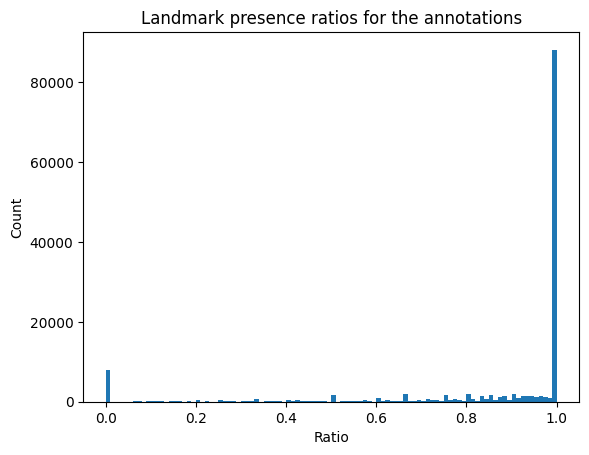

In [29]:
print('Number of annotations out of range:', len(out_of_range))
if len(out_of_range) > 0:
    print('Example of an out of range annotation:', out_of_range[0])
plt.hist(present_ratios, bins = 100)
plt.title('Landmark presence ratios for the annotations')
plt.xlabel('Ratio')
plt.ylabel('Count')
plt.show()

In [30]:
# Getting some statistics about the landmark presences

# We round the ratios to one decimal to more easily group them together
present_ratios_rounded = [round(x, 1 ) for x in present_ratios]
# We then count the rounded ratios
ratio_counts = Counter(present_ratios_rounded).items()

# We set some threshold for what ratio of frames the landmarks should be detected for
# E.g. threshold = 0.5 means 50% of the frames should have landmarks
threshold = 0.4
# We then filter to the ratios which meet this threshold, and sum their counts up
filtered_ratios = [x for x in ratio_counts if x[0] >= threshold]
anns_with_enough_frames = sum([x[1] for x in filtered_ratios])

# Total number of annotations
total_anns = len(present_ratios)
# Getting the percentage of annotations with a landmark-presence ratio >= threshold
num_frames_above_thresh = round(100*anns_with_enough_frames/total_anns, 2)

# Printing the analysis
print('Counts of frame presence ratios for annotations')
print(sorted(ratio_counts, key = lambda x: x[1], reverse = True))
print('-'*50)
print('{} annotations in total'.format(total_anns))
print('{} annotations reach the threshold number of present frames.'.format(anns_with_enough_frames))
print('{}% of annotations have at least {}% of frames present'.format(num_frames_above_thresh, threshold*100))
print('Average presence ratio:', round(np.mean(present_ratios),2))

Counts of frame presence ratios for annotations
[(1.0, 93108), (0.9, 12396), (0.8, 8515), (0.0, 8031), (0.7, 4365), (0.6, 3240), (0.5, 2502), (0.4, 1772), (0.2, 1601), (0.3, 1539), (0.1, 922)]
--------------------------------------------------
137991 annotations in total
125898 annotations reach the threshold number of present frames.
91.24% of annotations have at least 40.0% of frames present
Average presence ratio: 0.86
